In [1]:
#import modules required for machine learning
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report, roc_auc_score 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from tpot import TPOTClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFwe
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier

C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
#install tpot for optmisation stage later on
!pip install --upgrade tpot

In [3]:
#open count.rtab file to create first histogram
with open("counts.rtab", 'rt') as f:
    data = pd.read_table(f, sep="\t")
print(data.columns)

Index(['pattern_id', 'ERR084492.unitigs.fa', 'ERR084493.unitigs.fa',
       'ERR084494.unitigs.fa', 'ERR084496.unitigs.fa', 'ERR084497.unitigs.fa',
       'ERR084498.unitigs.fa', 'ERR084499.unitigs.fa', 'ERR084500.unitigs.fa',
       'ERR084501.unitigs.fa',
       ...
       'ERR223148.unitigs.fa', 'ERR223159.unitigs.fa', 'ERR223160.unitigs.fa',
       'ERR223161.unitigs.fa', 'ERR223162.unitigs.fa', 'ERR223163.unitigs.fa',
       'ERR223165.unitigs.fa', 'ERR223166.unitigs.fa', 'ERR223167.unitigs.fa',
       'ERR223168.unitigs.fa'],
      dtype='object', length=1093)


1092 unitigs, each has a column, each pattern has a row - and along that row is a 1 or a 0 if the unitig is present or not

ERR084492 is the isolate label
The pattern is the isolate name (1st column)
And presence is the 1 or 0
There are 300000 unitigs and 1092 isolates


To make the first histogram think of rows being samples and 
the columns as features. If you sum each you will get a count 
of the isolates per feature. Then make a histogram out of that.
Cols are unitigs, rows are isolates. So sum each row and make a histogram out of that.

0         1087
1         1087
2         1087
3         1088
4         1088
          ... 
305057       9
305058       3
305059       5
305060       4
305061       1
Length: 305062, dtype: int64


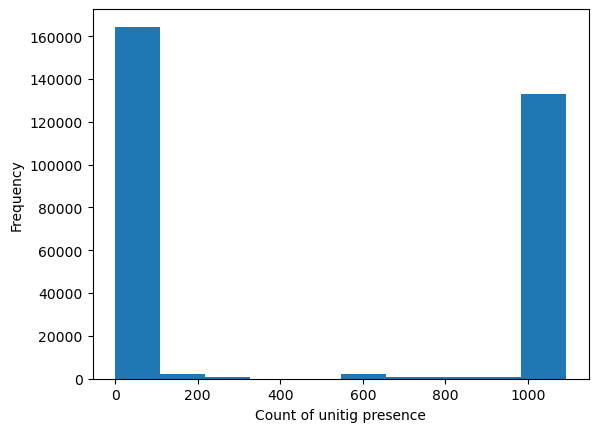

In [4]:
#HISTOGRAM 1 
summary = data.iloc[:,1:].sum(axis=1)
print(summary)
summary.plot.hist()
plt.xlabel('Count of unitig presence')
plt.show()

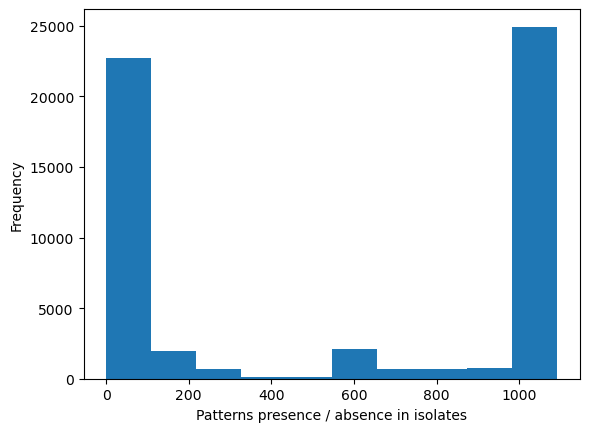

In [5]:
# The below generates the vcf file
# perl variants_to_patterns -i counts.rtab -o output.vcf -c conversion.txt (command line instruction)
# create a histogram showing patterns presence/absence in isolates
with open("output.vcf", 'rt') as f:
    data_vcf = pd.read_table(f, sep="\t")
summary_vcf = data_vcf.iloc[:,1:].sum(axis=1)
summary_vcf.plot.hist()
plt.xlabel('Patterns presence / absence in isolates')
plt.show()


In [6]:
# View the head of the dataset
head_dataset = (data_vcf.head())

head_dataset = data_vcf #.head(N)
print(data_vcf.head())

   id  ERR084492.unitigs.fa  ERR084493.unitigs.fa  ERR084494.unitigs.fa  \
0   1                     1                     1                     1   
1   2                     1                     1                     1   
2   3                     1                     1                     1   
3   4                     1                     1                     1   
4   5                     1                     1                     1   

   ERR084496.unitigs.fa  ERR084497.unitigs.fa  ERR084498.unitigs.fa  \
0                     1                     1                     1   
1                     1                     1                     1   
2                     1                     1                     1   
3                     1                     1                     1   
4                     1                     1                     1   

   ERR084499.unitigs.fa  ERR084500.unitigs.fa  ERR084501.unitigs.fa  ...  \
0                     1                     1 

In [7]:
#make it into a dataframe
head_dataset_df = pd.DataFrame(head_dataset)
print(head_dataset_df)

          id  ERR084492.unitigs.fa  ERR084493.unitigs.fa  \
0          1                     1                     1   
1          2                     1                     1   
2          3                     1                     1   
3          4                     1                     1   
4          5                     1                     1   
...      ...                   ...                   ...   
54719  54720                     0                     0   
54720  54721                     0                     0   
54721  54722                     0                     0   
54722  54723                     0                     0   
54723  54724                     0                     0   

       ERR084494.unitigs.fa  ERR084496.unitigs.fa  ERR084497.unitigs.fa  \
0                         1                     1                     1   
1                         1                     1                     1   
2                         1                     1     

In [8]:
# Remove the 'unitigs.fa' part from the sample names
head_dataset_df.columns = head_dataset_df.columns.str.replace('.unitigs.fa', '', regex=False)

# View the modified DataFrame
print(head_dataset_df.head())

   id  ERR084492  ERR084493  ERR084494  ERR084496  ERR084497  ERR084498  \
0   1          1          1          1          1          1          1   
1   2          1          1          1          1          1          1   
2   3          1          1          1          1          1          1   
3   4          1          1          1          1          1          1   
4   5          1          1          1          1          1          1   

   ERR084499  ERR084500  ERR084501  ...  ERR223148  ERR223159  ERR223160  \
0          1          1          1  ...          1          1          1   
1          1          1          1  ...          1          1          1   
2          1          1          1  ...          1          1          1   
3          1          1          1  ...          1          1          1   
4          1          1          1  ...          1          1          1   

   ERR223161  ERR223162  ERR223163  ERR223165  ERR223166  ERR223167  ERR223168  
0          

In [9]:
# Transpose the DataFrame
transposed_df = head_dataset_df.transpose()

# View the transposed DataFrame
print(transposed_df.head())

           0      1      2      3      4      5      6      7      8      \
id             1      2      3      4      5      6      7      8      9   
ERR084492      1      1      1      1      1      1      1      0      1   
ERR084493      1      1      1      1      1      1      1      1      1   
ERR084494      1      1      1      1      1      1      1      1      1   
ERR084496      1      1      1      1      1      1      1      1      1   

           9      ...  54714  54715  54716  54717  54718  54719  54720  54721  \
id            10  ...  54715  54716  54717  54718  54719  54720  54721  54722   
ERR084492      1  ...      0      0      0      0      0      0      0      0   
ERR084493      1  ...      0      0      0      0      0      0      0      0   
ERR084494      1  ...      0      0      0      0      0      0      0      0   
ERR084496      1  ...      0      0      0      0      0      0      0      0   

           54722  54723  
id         54723  54724  
ERR0

In [10]:
num_patterns = len(summary_vcf) - 1  # Subtract 1 to exclude the 'id' column
print("Number of patterns in the dataset:", num_patterns)

#no of patterns = genetic features (what we use to train the models predictive behaviour on)

Number of patterns in the dataset: 54723


In [11]:
# With the DataFrame called data_vcf containing the data
# Calculate the sum of each row, excluding the first column
row_summary_vcf = data_vcf.iloc[:, 1:].sum(axis=1)

# Filter rows based on the conditions: filter out patterns in only one isolate (or all isolates but one)
row_summary_vcf_filtered = row_summary_vcf[(row_summary_vcf > 1) & (row_summary_vcf < 1091)]

# Count the number of patterns removed
patterns_removed = len(row_summary_vcf) - len(row_summary_vcf_filtered)

# Print the number of patterns removed
print(f"Number of patterns removed: {patterns_removed}")


Number of patterns removed: 2114


In [12]:
#view row_summary_vcf_filtered
print(row_summary_vcf_filtered.head())

0    1087
1    1088
2    1087
3    1089
4    1087
dtype: int64


In [13]:
# Convert the Series to a DataFrame
row_summary_vcf_filtered = pd.DataFrame(row_summary_vcf_filtered)

# Rename the columns
row_summary_vcf_filtered.columns = ['var_count']

# Add 1 to the index to bring it in line with the original ID
row_summary_vcf_filtered.index = row_summary_vcf_filtered.index + 1

# Rename the index name to 'pattern_id'
row_summary_vcf_filtered.index.name = 'pattern_id'

# View the updated DataFrame
print(row_summary_vcf_filtered.head())

            var_count
pattern_id           
1                1087
2                1088
3                1087
4                1089
5                1087


In [14]:
# View the transposed DataFrame
print(transposed_df)

           0      1      2      3      4      5      6      7      8      \
id             1      2      3      4      5      6      7      8      9   
ERR084492      1      1      1      1      1      1      1      0      1   
ERR084493      1      1      1      1      1      1      1      1      1   
ERR084494      1      1      1      1      1      1      1      1      1   
ERR084496      1      1      1      1      1      1      1      1      1   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
ERR223163      1      1      1      1      1      1      1      1      1   
ERR223165      1      1      1      1      1      1      1      1      1   
ERR223166      1      1      1      1      1      1      1      1      1   
ERR223167      1      1      1      1      1      1      1      1      1   
ERR223168      1      1      1      1      1      1      1      1      1   

           9      ...  54714  54715  54716  54717  54718  54719  54720  54721  \
id    

In [15]:
# Move the row with index 'id' to column names and rename it to 'ENA_accession'
#transposed_df.columns = transposed_df.loc['id'].values
#transposed_df = transposed_df.drop('id')

transposed_df['ENA_accession'] = transposed_df.index.values

# Print the updated DataFrame
print(transposed_df)

           0  1  2  3  4  5  6  7  8   9  ...  54715  54716  54717  54718  \
id         1  2  3  4  5  6  7  8  9  10  ...  54716  54717  54718  54719   
ERR084492  1  1  1  1  1  1  1  0  1   1  ...      0      0      0      0   
ERR084493  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR084494  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR084496  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
...       .. .. .. .. .. .. .. .. ..  ..  ...    ...    ...    ...    ...   
ERR223163  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR223165  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR223166  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR223167  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   
ERR223168  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0   

           54719  54720  54721  54722  54723  ENA_accession  
id         54

In [16]:
# check if ENA_accession is column in transposed_df
if 'ENA_accession' in transposed_df.columns:
    print("'ENA_accession' is a column in the DataFrame")
else:
    print("'ENA_accession' is not a column in the DataFrame")


'ENA_accession' is a column in the DataFrame


In [17]:
# reset the index and rename it
transposed_df = transposed_df.reset_index()
transposed_df = transposed_df.rename(columns={'index': 'ENA_accession'})
print(transposed_df.head())

   ENA_accession  0  1  2  3  4  5  6  7  8  ...  54715  54716  54717  54718  \
0             id  1  2  3  4  5  6  7  8  9  ...  54716  54717  54718  54719   
1      ERR084492  1  1  1  1  1  1  1  0  1  ...      0      0      0      0   
2      ERR084493  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   
3      ERR084494  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   
4      ERR084496  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   

   54719  54720  54721  54722  54723  ENA_accession  
0  54720  54721  54722  54723  54724             id  
1      0      0      0      0      0      ERR084492  
2      0      0      0      0      0      ERR084493  
3      0      0      0      0      0      ERR084494  
4      0      0      0      0      0      ERR084496  

[5 rows x 54726 columns]


In [18]:
# check if ENA_accession is column in transposed_df
if 'ENA_accession' in transposed_df.columns:
    print("'ENA_accession' is a column in the DataFrame")
else:
    print("'ENA_accession' is not a column in the DataFrame")

'ENA_accession' is a column in the DataFrame


In [19]:
outliers = ['ERR171907', 'ERR171908', 'ERR109547', 'ERR177226', 'ERR158992', 'ERR084680',
            'ERR177155', 'ERR223120', 'ERR223125', 'ERR156506', 'ERR156441', 'ERR177156']

# Check if outliers are present in the transposed DataFrame
outliers_present = transposed_df.columns.isin(outliers)

# Check if any outliers are present
if outliers_present.any():
    print("Outliers are present in the transposed DataFrame.")
else:
    print("No outliers are present in the transposed DataFrame.")


No outliers are present in the transposed DataFrame.


In [20]:
# load in metadata strain-ids.csv (converted manually from strain-ids.xls) to pd

import pandas as pd

metadata = pd.read_excel("strain-ids.xls")

outliers = ['ERR171907','ERR171908', 'ERR109547', 'ERR177226', 'ERR158992', 'ERR084680',
            'ERR177155', 'ERR223120', 'ERR223125', 'ERR156506', 'ERR156441', 'ERR177156']

# filter out outliers
metadata_filtered = metadata[~metadata['ENA_accession'].isin(outliers)]
metadata_filtered.index =metadata_filtered.index + 1



In [21]:
countries = ['Northern Ireland', 'Ireland', 'Scotland', 'Wales']
regions = ['South-East', 'West-Midlands', 'North-West', 'North-Central', 'Central-East Midlands', 'North-East', 'SouthCentral', 'South-West', 'East', 'South-East']
regions.sort(reverse=True, key=len)
hospitals = ['East 2G', 'Northern IrelandD', 'IrelandC', 'South-EastD',
       'West-MidlandsA', 'WalesA', 'Northern IrelandA', 'WalesB',
       'South-WestB', 'East-1C', 'North-West 1A', 'IrelandA',
       'West-MidlandsC', 'North-CentralB', 'ScotlandG', 'North-West 2A',
       'North-CentralA', 'ScotlandD', 'East 2B', 'Central-East MidlandsB',
       'North-East 1A', 'West-MidlandsB', 'SouthCentralA', 'South-EastC',
       'South-WestD', 'Central-East MidlandsA', 'ScotlandE', 'East-1A',
       'ScotlandC', 'East 2A', 'South-EastB', 'ScotlandF', 'South-WestA',
       'South-EastA', 'ScotlandH', 'ScotlandA', 'East-1D',
       'Northern IrelandB', 'IrelandB', 'ScotlandB', 'WalesC',
       'South-WestC', 'North-East 2A', 'Northern IrelandC', 'East 2C',
       'East-1E', 'East-1F', 'East-1B', 'East 2F', 'East 2E', 'East 2D',
       'East-1G']
hospitals.sort(reverse=True)
print(hospitals)

['West-MidlandsC', 'West-MidlandsB', 'West-MidlandsA', 'WalesC', 'WalesB', 'WalesA', 'SouthCentralA', 'South-WestD', 'South-WestC', 'South-WestB', 'South-WestA', 'South-EastD', 'South-EastC', 'South-EastB', 'South-EastA', 'ScotlandH', 'ScotlandG', 'ScotlandF', 'ScotlandE', 'ScotlandD', 'ScotlandC', 'ScotlandB', 'ScotlandA', 'Northern IrelandD', 'Northern IrelandC', 'Northern IrelandB', 'Northern IrelandA', 'North-West 2A', 'North-West 1A', 'North-East 2A', 'North-East 1A', 'North-CentralB', 'North-CentralA', 'IrelandC', 'IrelandB', 'IrelandA', 'East-1G', 'East-1F', 'East-1E', 'East-1D', 'East-1C', 'East-1B', 'East-1A', 'East 2G', 'East 2F', 'East 2E', 'East 2D', 'East 2C', 'East 2B', 'East 2A', 'Central-East MidlandsB', 'Central-East MidlandsA']


In [22]:
# wales has a,b,c ; scotland has a-h ; ireland has a-c ; northern ireland has a-d
non_england_regions = ['Wales'+x for x in 'ABC']
non_england_regions += ['Ireland'+x for x in 'ABC']
non_england_regions += ['Northern Ireland'+x for x in 'ABCD']
non_england_regions += ['Scotland'+x for x in 'ABCDEFGH']

def convert_to_country(hospital):
    country = ""
    for c in countries:
        if c in hospital:
            country = c
            break
        # if no country found, must be england, and region is the whole substring found
        country = "England"
    return country

def convert_to_region(hospital):
    country = ""
    region = ""
    for c in countries:
        if c in hospital:
            country = c
            break
        # if no country found, must be england, and region is the whole substring found
        country = "England"
        for r in regions:
            if r in hospital:
                region = r
                return region
    for r in non_england_regions:
        if r in hospital:
            region = r
    return region

metadata_filtered['Country'] = metadata_filtered['Hospital'].apply(convert_to_country)
metadata_filtered['Region'] = metadata_filtered['Hospital'].apply(convert_to_region)

print("Head of metadata_filtered:")
print(metadata_filtered.head())

Head of metadata_filtered:
  ENA_accession strainid Hospital Incl/Excl  Country Region
1     ERR084492  ASARM61  East 2G   Include  England   East
2     ERR084493  ASARM59  East 2G   Include  England   East
3     ERR084494  ASARM62  East 2G   Include  England   East
4     ERR084496  ASARM64  East 2G   Include  England   East
5     ERR084497  ASARM65  East 2G   Include  England   East


C:\Users\tq22677\AppData\Local\Temp\ipykernel_19888\1098455355.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['Country'] = metadata_filtered['Hospital'].apply(convert_to_country)
C:\Users\tq22677\AppData\Local\Temp\ipykernel_19888\1098455355.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['Region'] = metadata_filtered['Hospital'].apply(convert_to_region)


In [23]:
# Get the column names of transposed_df and metadata_filtered
transposed_columns = transposed_df.columns
metadata_columns = metadata_filtered.columns

# Find common columns
common_columns = set(transposed_columns) & set(metadata_columns)

# Check if there are any common columns
if common_columns:
    print("Common columns:", common_columns)
else:
    print("No common columns found.")


Common columns: {'ENA_accession'}


In [24]:
# Convert 'ENA_accession' column to string data type in both dataframes
metadata_filtered['ENA_accession'] = metadata_filtered['ENA_accession'].astype(str)
transposed_df.columns = transposed_df.columns.astype(str)
# remove the final column of transposed_df
transposed_df = transposed_df.iloc[:, :-1]


# Perform the join using 'ENA_accession' as the common column
print(metadata_filtered.head())
print(transposed_df.head())

merged_df = metadata_filtered.set_index('ENA_accession').join(transposed_df.set_index('ENA_accession'), rsuffix='_transposed')
#merged_df = metadata_filtered.join(transposed_df, on='ENA_accession', rsuffix='_transposed')
#commented out sampling step
#N = 1000
#merged_df = merged_df.sample(n=N, replace=False)
merged_df = merged_df.sort_values(by='Hospital')
# Print the merged dataframe
print(merged_df.head())

C:\Users\tq22677\AppData\Local\Temp\ipykernel_19888\689334311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_filtered['ENA_accession'] = metadata_filtered['ENA_accession'].astype(str)


  ENA_accession strainid Hospital Incl/Excl  Country Region
1     ERR084492  ASARM61  East 2G   Include  England   East
2     ERR084493  ASARM59  East 2G   Include  England   East
3     ERR084494  ASARM62  East 2G   Include  England   East
4     ERR084496  ASARM64  East 2G   Include  England   East
5     ERR084497  ASARM65  East 2G   Include  England   East
  ENA_accession  0  1  2  3  4  5  6  7  8  ...  54714  54715  54716  54717  \
0            id  1  2  3  4  5  6  7  8  9  ...  54715  54716  54717  54718   
1     ERR084492  1  1  1  1  1  1  1  0  1  ...      0      0      0      0   
2     ERR084493  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   
3     ERR084494  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   
4     ERR084496  1  1  1  1  1  1  1  1  1  ...      0      0      0      0   

   54718  54719  54720  54721  54722  54723  
0  54719  54720  54721  54722  54723  54724  
1      0      0      0      0      0      0  
2      0      0      0     

In [25]:
merged_df.to_csv('merged_data.csv', index=True)

   1  2  3  4  5  6  7  8  9  10  ...  54715  54716  54717  54718  54719  \
0  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
1  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
2  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
3  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
4  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   

   54720  54721  54722  54723  54724  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 54724 columns]
0    Central-East MidlandsA
1    Central-East MidlandsA
2    Central-East MidlandsA
3    Central-East MidlandsA
4    Central-East MidlandsA
Name: Hospital, dtype: object
FITTING random_forest CLASSIFIER FOR COLUMN Hospital
Selecting features using kbest all


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    8   103   453   631  1022  2007  3823 37482 42891 44802] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Number of selected features: 100
Selected features: [  453   630   631   798  1015  1022  2005  2007  2557  3235  3784  3786
  3820  3823  4251  5802  6418  6604  8008  8010  8012  8013  9092  9244
  9246  9879 10389 10668 10710 10715 11773 13497 13669 13892 14284 14286
 14661 15385 16513 16622 16831 17212 18321 18355 18641 19444 19447 20105
 20973 22663 22664 22665 23539 23597 23659 23697 24502 24710 25003 25786
 26823 30545 30546 30642 30665 33444 34551 35489 35494 35499 35508 35513
 35524 35525 35526 36771 37482 38237 41349 41791 41801 42891 44599 44802
 45187 45194 45196 45199 45205 45640 46347 46466 48401 48466 49324 49370
 49945 52535 52988 53902]
Fitting model...
Cross validation scores: [0.23351648 0.23076923 0.24175824]
Mean cross validation score: 0.23534798534798537


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

Classification report:
                        precision    recall  f1-score   support

Central-East MidlandsA       0.55      0.24      0.33        25
Central-East MidlandsB       0.00      0.00      0.00         5
               East 2A       0.00      0.00      0.00         3
               East 2B       0.00      0.00      0.00        30
               East 2C       0.00      0.00      0.00         2
               East 2D       0.19      0.97      0.31       162
               East 2E       0.00      0.00      0.00         1
               East 2F       0.00      0.00      0.00         1
               East 2G       1.00      0.01      0.02       161
               East-1A       0.00      0.00      0.00        20
               East-1B       0.00      0.00      0.00         2
               East-1C       0.00      0.00      0.00         7
               East-1D       0.00      0.00      0.00         2
               East-1E       0.00      0.00      0.00         2
               E

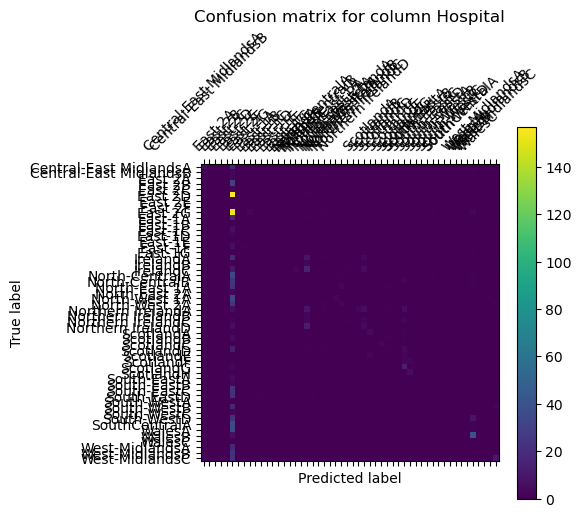

Precision: 0.14229438500377264
Recall: 0.12595311548474672
F1 score: 0.10707764771279814
**************************************************
       algorithm     score  precision    recall        f1
0  random_forest  0.235348   0.142294  0.125953  0.107078


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


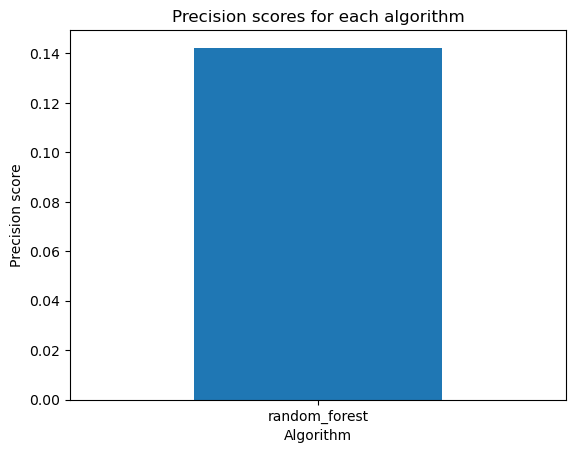

In [26]:
# column_label is what is to be predicted
def run_ML(column_label, algorithm, reports_only=False, feature_sel_method="noselection"):
    """    hospital_label_encoder = LabelEncoder()
    merged_df[column_label] = hospital_label_encoder.fit_transform(merged_df[column_label])
    print(merged_df.head())
    """
    #X = merged_df[['strainid', 'average_coverage']]
    # make X the ENA_accession and strainid columns
    X = merged_df.iloc[:,5:].reset_index(drop=True)
    X.columns = [str(int(col)+1) for col in X.columns]
    if not reports_only:
        print(X.head())
    #y = merged_df['Hospital']
    y = merged_df[column_label]
    y = y.reset_index(drop=True)
    if not reports_only:
        print(y.head())
     # split train test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=True) #, random_state=42)


    print(f"FITTING {algorithm} CLASSIFIER FOR COLUMN {column_label}")
    #implement feature selection methods: kbest, select percentile, PCA

    if algorithm == "random_forest":
        rf_classifier = RandomForestClassifier(n_estimators=20) #100)
        if feature_sel_method == "kbest":
            #k = int(feature_sel_method[5:])
            print(f"Selecting features using kbest all")
            kbest = SelectKBest(score_func=f_classif, k=100)
            X = kbest.fit_transform(X, y)
            num_selected_features = kbest.k
            print(f"Number of selected features: {num_selected_features}")
            # display the selected features
            print(f"Selected features: {kbest.get_support(indices=True)}")
    elif algorithm == "logistic_regression":
        rf_classifier = LogisticRegression()
    elif algorithm == "svm":
        rf_classifier = SVC(gamma='auto')
    elif algorithm == "knn":
        # Need to test this:
        parameters = {
            "n_neighbors": range(1, 51),
        }
        #rf_classifier = KNeighborsClassifier(n_neighbors=3)
        rf_classifier = GridSearchCV(KNeighborsClassifier(), parameters)  # KNN classifier
    elif algorithm == "mlp":
        rf_classifier = MLPClassifier(alpha=1, max_iter=1000)
    else:
        print("No valid algorithm specified.")
        return  # exit the function


    if not reports_only:
        print("Fitting model...")
        # this below fits all the data
        #scores_fit = rf_classifier.fit(X, y)
        scores = cross_val_score(rf_classifier, X, y, cv=3)
        print("Cross validation scores:", scores)
        print("Mean cross validation score:", scores.mean())


    # this runs 3 times cross val to get other metrics
    predicted = cross_val_predict(rf_classifier, X, y, cv=3)
    #predicted_fit = rf_classifier.predict(X)

    cr = classification_report(y, predicted)  
    if not reports_only:
        print("Classification report:") 
        print(cr) 
    else:

        with open(f"class_reports.txt", "a") as f:
            f.write(f"{algorithm} CLASSIFICATION REPORT FOR COLUMN {column_label}\n\n")
            f.write(cr+"\n"+"-"*50+"\n")

    #class_names = hospital_label_encoder.classes_
    #extract unique class names from the country column

    if not reports_only:
        class_names = merged_df['Hospital'].unique()
        cm = confusion_matrix(y, predicted)
        print("Confusion matrix:")
        print(cm)
        # plot the confusion matrix
        plt.matshow(cm)
        plt.title('Confusion matrix for column ' + column_label)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)), class_names)

        plt.show()


        precision = precision_score(y, predicted, average='macro')
        recall = recall_score(y, predicted, average='macro')
        f1 = f1_score(y, predicted, average='macro')
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        print("*"*50)
        return sum(scores)/len(scores), precision, recall, f1
        #return scores, precision, recall, f1
    print("*" * 50)


with open("class_reports.txt", "w") as f:
    f.write("")

# feature selection for random forest
DO_ML = True
if DO_ML:
    algos = ["random_forest"]

    # create dataframe to store results
    results_df = pd.DataFrame(columns=["algorithm", "score", "precision", "recall", "f1"])


    for algo in algos:
        #for k in range(1, 30):
        results = run_ML('Hospital', algo, feature_sel_method=f"kbest") #, reports_only=True)
        # update results_df
        #for i, col in enumerate(["scores", "precision", "recall", "f1"]):
        results_df.loc[len(results_df)] = [algo, results[0], results[1], results[2], results[3]]
    print(results_df)
    # plot bar chart of precision scores from each algorithm
    results_df.plot.bar(x="algorithm", y="precision", rot=0)
    plt.title("Precision scores for each algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel("Precision score")
    legend = plt.legend()
    legend.remove()
    plt.show()

   1  2  3  4  5  6  7  8  9  10  ...  54715  54716  54717  54718  54719  \
0  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
1  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
2  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
3  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
4  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   

   54720  54721  54722  54723  54724  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 54724 columns]
0    Central-East MidlandsA
1    Central-East MidlandsA
2    Central-East MidlandsA
3    Central-East MidlandsA
4    Central-East MidlandsA
Name: Hospital, dtype: object
FITTING random_forest CLASSIFIER FOR COLUMN Hospital
Selecting top 100% features using SelectPercentile


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    8   103   453   631  1022  2007  3823 37482 42891 44802] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Number of selected features: 54724
Selected feature indices: [    0     1     2 ... 54721 54722 54723]
Fitting model...


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross validation scores: [0.50274725 0.51648352 0.59340659]
Mean cross validation score: 0.5375457875457875


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Prec

Classification report:
                        precision    recall  f1-score   support

Central-East MidlandsA       0.29      0.28      0.29        25
Central-East MidlandsB       0.00      0.00      0.00         5
               East 2A       0.00      0.00      0.00         3
               East 2B       0.32      0.37      0.34        30
               East 2C       0.00      0.00      0.00         2
               East 2D       0.63      0.79      0.70       162
               East 2E       0.00      0.00      0.00         1
               East 2F       0.00      0.00      0.00         1
               East 2G       0.63      0.71      0.67       161
               East-1A       0.00      0.00      0.00        20
               East-1B       0.00      0.00      0.00         2
               East-1C       0.38      0.43      0.40         7
               East-1D       1.00      0.50      0.67         2
               East-1E       0.00      0.00      0.00         2
               E

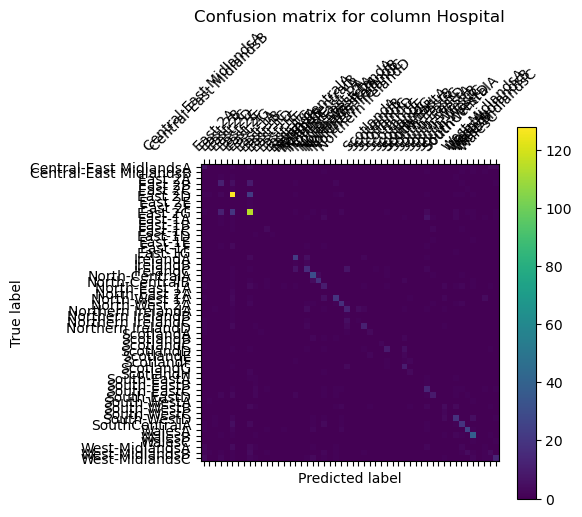

Precision: 0.3097762503092655
Recall: 0.30022804945362436
F1 score: 0.29891583677021194
**************************************************
       algorithm     score  precision    recall        f1
0  random_forest  0.537546   0.309776  0.300228  0.298916


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


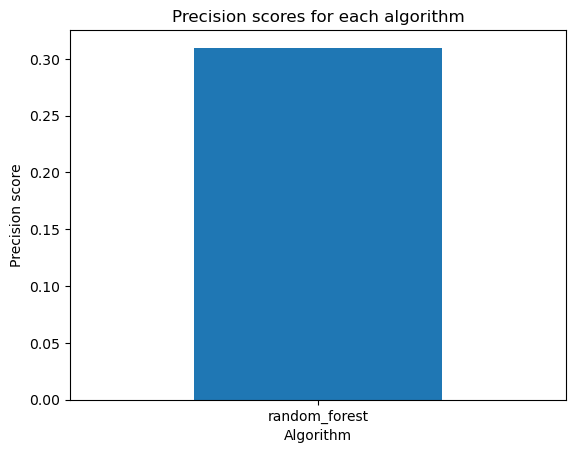

In [47]:
# column_label is what is to be predicted
def run_ML(column_label, algorithm, reports_only=False, feature_sel_method="noselection", percentile=100):
    """    hospital_label_encoder = LabelEncoder()
    merged_df[column_label] = hospital_label_encoder.fit_transform(merged_df[column_label])
    print(merged_df.head())
    """
    #X = merged_df[['strainid', 'average_coverage']]
    # make X the ENA_accession and strainid columns
    X = merged_df.iloc[:,5:].reset_index(drop=True)
    X.columns = [str(int(col)+1) for col in X.columns]
    if not reports_only:
        print(X.head())
    #y = merged_df['Hospital']
    y = merged_df[column_label]
    y = y.reset_index(drop=True)
    if not reports_only:
        print(y.head())
     # split train test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=True) #, random_state=42)


    print(f"FITTING {algorithm} CLASSIFIER FOR COLUMN {column_label}")
    #code implementing select percentile

    if algorithm == "random_forest":
        rf_classifier = RandomForestClassifier(n_estimators=20) 
        if feature_sel_method == "percentile":
            print(f"Selecting top {percentile}% features using SelectPercentile")
            selector = SelectPercentile(score_func=f_classif, percentile=percentile)
            X = selector.fit_transform(X, y)
            num_selected_features = X.shape[1]
            print(f"Number of selected features: {num_selected_features}")
            # display the selected features
            selected_feature_indices = selector.get_support(indices=True)
            print(f"Selected feature indices: {selected_feature_indices}")
    elif algorithm == "logistic_regression":
        rf_classifier = LogisticRegression()
    elif algorithm == "svm":
        rf_classifier = SVC(gamma='auto')
    elif algorithm == "knn":
        # Need to test this:
        parameters = {
            "n_neighbors": range(1, 51),
        }
        #rf_classifier = KNeighborsClassifier(n_neighbors=3)
        rf_classifier = GridSearchCV(KNeighborsClassifier(), parameters)  # KNN classifier
    elif algorithm == "mlp":
        rf_classifier = MLPClassifier(alpha=1, max_iter=1000)
    else:
        print("No valid algorithm specified.")
        return  # exit the function


    if not reports_only:
        print("Fitting model...")
        # this below fits all the data
        #scores_fit = rf_classifier.fit(X, y)
        scores = cross_val_score(rf_classifier, X, y, cv=3)
        print("Cross validation scores:", scores)
        print("Mean cross validation score:", scores.mean())


    # this runs 3 times cross val to get other metrics
    predicted = cross_val_predict(rf_classifier, X, y, cv=3)
    #predicted_fit = rf_classifier.predict(X)

    cr = classification_report(y, predicted)  # &&&
    if not reports_only:
        print("Classification report:") # &&&
        print(cr) # &&&
    else:

        with open(f"class_reports.txt", "a") as f:
            f.write(f"{algorithm} CLASSIFICATION REPORT FOR COLUMN {column_label}\n\n")
            f.write(cr+"\n"+"-"*50+"\n")

    #class_names = hospital_label_encoder.classes_
    #extract unique class names from the country column

    if not reports_only:
        class_names = merged_df['Hospital'].unique()
        cm = confusion_matrix(y, predicted)
        print("Confusion matrix:")
        print(cm)
        # plot the confusion matrix
        plt.matshow(cm)
        plt.title('Confusion matrix for column ' + column_label)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)), class_names)

        plt.show()


        precision = precision_score(y, predicted, average='macro')
        recall = recall_score(y, predicted, average='macro')
        f1 = f1_score(y, predicted, average='macro')
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        print("*"*50)
        return sum(scores)/len(scores), precision, recall, f1
        #return scores, precision, recall, f1
    print("*" * 50)


with open("class_reports.txt", "w") as f:
    f.write("")

# feature selection for random forest
DO_ML = True
if DO_ML:
    algos = ["random_forest"]

# Create a dataframe to store results
results_df = pd.DataFrame(columns=["algorithm", "score", "precision", "recall", "f1"])

for algo in algos:
    if algo == "random_forest":
        feature_sel_method = "percentile"  # Define the feature selection method for this algorithm
        if feature_sel_method == "percentile":
            results = run_ML('Hospital', algo, feature_sel_method=feature_sel_method, percentile= 100)
        # update results_df
        results_df.loc[len(results_df)] = [algo, results[0], results[1], results[2], results[3]]

# Print the results dataframe
print(results_df)

# Plot bar chart of precision scores from each algorithm
results_df.plot.bar(x="algorithm", y="precision", rot=0)
plt.title("Precision scores for each algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Precision score")
legend = plt.legend()
legend.remove()
plt.show()


   1  2  3  4  5  6  7  8  9  10  ...  54715  54716  54717  54718  54719  \
0  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
1  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
2  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
3  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   
4  1  1  1  1  1  1  1  1  1   1  ...      0      0      0      0      0   

   54720  54721  54722  54723  54724  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 54724 columns]
0    Central-East Midlands
1    Central-East Midlands
2    Central-East Midlands
3    Central-East Midlands
4    Central-East Midlands
Name: Region, dtype: object
FITTING random_forest CLASSIFIER FOR COLUMN Region
Applying PCA with 1000 components
Explained variance ratio of selecte

C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Cross validation scores: [0.40934066 0.43406593 0.39010989]
Mean cross validation score: 0.4111721611721612


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Prec

Classification report:
                       precision    recall  f1-score   support

Central-East Midlands       0.00      0.00      0.00        30
                 East       0.40      0.96      0.56       401
             IrelandA       0.00      0.00      0.00        33
             IrelandB       0.00      0.00      0.00         3
             IrelandC       0.43      0.09      0.14        35
        North-Central       0.55      0.17      0.26        64
           North-East       0.00      0.00      0.00        30
           North-West       0.10      0.02      0.03        65
    Northern IrelandA       0.75      0.11      0.19        28
    Northern IrelandB       0.00      0.00      0.00         2
    Northern IrelandC       0.00      0.00      0.00         9
    Northern IrelandD       1.00      0.09      0.17        22
            ScotlandA       0.00      0.00      0.00         6
            ScotlandB       0.00      0.00      0.00         6
            ScotlandC       0.0

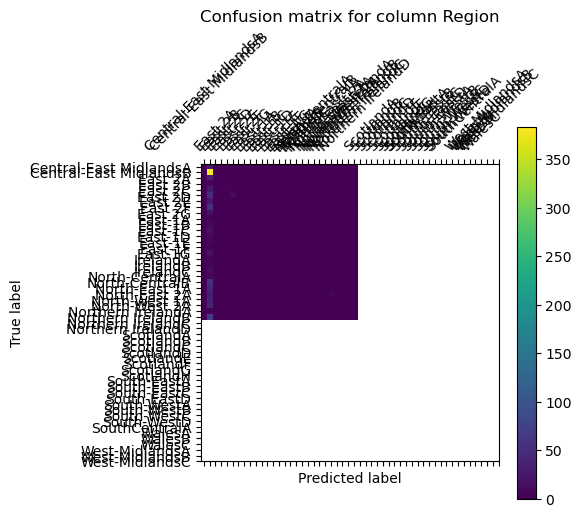

Precision: 0.2111662333884556
Recall: 0.0673581135062397
F1 score: 0.07386887146017333
**************************************************
       algorithm     score  precision    recall        f1
0  random_forest  0.411172   0.211166  0.067358  0.073869


C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


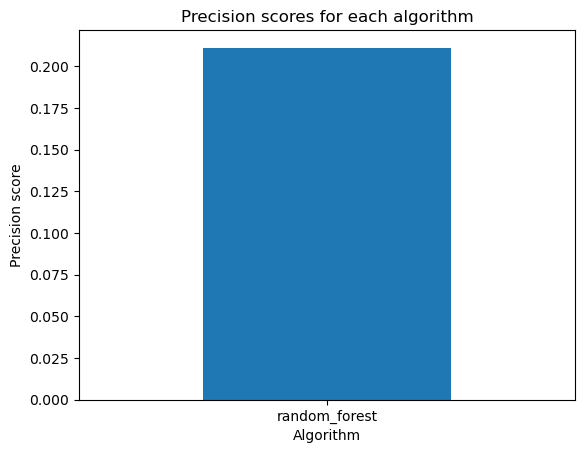

In [55]:
# column_label is what is to be predicted
def run_ML(column_label, algorithm, reports_only=False, pca=True, pca_components=1000):
    """    hospital_label_encoder = LabelEncoder()
    merged_df[column_label] = hospital_label_encoder.fit_transform(merged_df[column_label])
    print(merged_df.head())
    """
    #X = merged_df[['strainid', 'average_coverage']]
    # make X the ENA_accession and strainid columns
    X = merged_df.iloc[:,5:].reset_index(drop=True)
    X.columns = [str(int(col)+1) for col in X.columns]
    if not reports_only:
        print(X.head())
    #y = merged_df['Hospital']
    y = merged_df[column_label]
    y = y.reset_index(drop=True)
    if not reports_only:
        print(y.head())
     # split train test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=True) #, random_state=42)


    print(f"FITTING {algorithm} CLASSIFIER FOR COLUMN {column_label}")
    #code implementing feature selection: PCA
    
    
    if algorithm == "random_forest":
        rf_classifier = RandomForestClassifier(n_estimators=20) 
        if pca:
            print(f"Applying PCA with {pca_components} components")
            pca_instance = PCA(n_components=pca_components)
            X_pca = pca_instance.fit_transform(X)
            print(f"Explained variance ratio of selected components: {pca_instance.explained_variance_ratio_}")
            # go through pca until >95% of variance is explained
            # and remove any components that don't explain much variance
            var_sum = 0
            explanation_threshold = 0.95
            """
            Suppose 99% returns 20000 component.
            But 95% only requires 5000 components.
            Do you want to quadruple the size of your input dat for an extra 4%?
            
            """
            n_components = 1
            for v in pca_instance.explained_variance_ratio_: # e.g. [0.5, 0.4, 0.05, 0.03, 0.02]
                var_sum += v
                print(f"% variance explained by {n_components} components is {var_sum}")
                if var_sum < explanation_threshold:
                    n_components += 1
                else:
                    break
            X = X_pca[:,:n_components] # Update X with the PCA-transformed features
    elif algorithm == "logistic_regression":
        rf_classifier = LogisticRegression()
    elif algorithm == "svm":
        rf_classifier = SVC(gamma='auto')
    elif algorithm == "knn":
        # Need to test this:
        parameters = {
            "n_neighbors": range(1, 51),
        }
        # rf_classifier = KNeighborsClassifier(n_neighbors=3)
        rf_classifier = GridSearchCV(KNeighborsClassifier(), parameters)  # KNN classifier
    elif algorithm == "mlp":
        rf_classifier = MLPClassifier(alpha=1, max_iter=1000)
    else:
        print("No valid algorithm specified.")
        return  # exit the function

    if not reports_only:
        print("Fitting model...")
        # this below fits all the data
        #scores_fit = rf_classifier.fit(X, y)
        scores = cross_val_score(rf_classifier, X, y, cv=3)
        print("Cross validation scores:", scores)
        print("Mean cross validation score:", scores.mean())


    # this runs 3 times cross val to get other metrics
    predicted = cross_val_predict(rf_classifier, X, y, cv=3)
    #predicted_fit = rf_classifier.predict(X)

    cr = classification_report(y, predicted)  # &&&
    if not reports_only:
        print("Classification report:") # &&&
        print(cr) # &&&
    else:

        with open(f"class_reports.txt", "a") as f:
            f.write(f"{algorithm} CLASSIFICATION REPORT FOR COLUMN {column_label}\n\n")
            f.write(cr+"\n"+"-"*50+"\n")

    #class_names = hospital_label_encoder.classes_
    #extract unique class names from the country column

    if not reports_only:
        class_names = merged_df['Hospital'].unique()
        cm = confusion_matrix(y, predicted)
        print("Confusion matrix:")
        print(cm)
        # plot the confusion matrix
        plt.matshow(cm)
        plt.title('Confusion matrix for column ' + column_label)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)), class_names)

        plt.show()


        precision = precision_score(y, predicted, average='macro')
        recall = recall_score(y, predicted, average='macro')
        f1 = f1_score(y, predicted, average='macro')
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        print("*"*50)
        return sum(scores)/len(scores), precision, recall, f1
        #return scores, precision, recall, f1
    print("*" * 50)


with open("class_reports.txt", "w") as f:
    f.write("")

# feature selection for random forest
DO_ML = True
if DO_ML:
    algos = ["random_forest"]

    # create dataframe to store results
    results_df = pd.DataFrame(columns=["algorithm", "score", "precision", "recall", "f1"])


    for algo in algos:
        #percentile = (num_features_to_keep / total_features) * 100:
        results = run_ML('Region', algo, pca=True, pca_components=1000) #, reports_only=True)
        # update results_df
        #for i, col in enumerate(["scores", "precision", "recall", "f1"]):
        results_df.loc[len(results_df)] = [algo, results[0], results[1], results[2], results[3]]
    print(results_df)
    # plot bar chart of precision scores from each algorithm
    results_df.plot.bar(x="algorithm", y="precision", rot=0)
    plt.title("Precision scores for each algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel("Precision score")
    legend = plt.legend()
    legend.remove()
    plt.show()

In [29]:
#optimise model using TPOT for region using the optimal number of features found in previous stages and the best feature selection method
"""
# To get rid of N, simply comment out those two lines.
# To get rid of the the 80%, use .fit(X,y) instead of
# cross_val_predict()
X = merged_df.iloc[:,5:].reset_index(drop=True)
X.columns = [str(int(col)+1) for col in X.columns]
#y = merged_df['Hospital']
y = merged_df['Region']
y = y.reset_index(drop=True)

# TPOT
# X needs to have had a feature selection run on it
# add TPOT as an algorithm
# Feature selection using SelectPercentile
percentile = 10  # Adjust the percentile value as needed
selector = SelectPercentile(score_func=f_classif, percentile=percentile)
X_selected = selector.fit_transform(X, y)

# TPOT Classifier
tpot = TPOTClassifier(generations=50, population_size=50, verbosity=2,
                      scoring='f1_macro', cv=3,
                      n_jobs=-1)
tpot.fit(X, y)

# Display results
best_pipeline = tpot.fitted_pipeline_
print(best_pipeline)

# Export the best pipeline as a Python script
tpot.export('tpot_pipeline.py')

# Evaluate the pipeline on the test set
test_score = best_pipeline.score(X, y)
print("Test score (F1_macro):", test_score)
"""

'\n# To get rid of N, simply comment out those two lines.\n# To get rid of the the 80%, use .fit(X,y) instead of\n# cross_val_predict()\nX = merged_df.iloc[:,5:].reset_index(drop=True)\nX.columns = [str(int(col)+1) for col in X.columns]\n#y = merged_df[\'Hospital\']\ny = merged_df[\'Region\']\ny = y.reset_index(drop=True)\n\n# TPOT\n# X needs to have had a feature selection run on it\n# add TPOT as an algorithm\n# Feature selection using SelectPercentile\npercentile = 10  # Adjust the percentile value as needed\nselector = SelectPercentile(score_func=f_classif, percentile=percentile)\nX_selected = selector.fit_transform(X, y)\n\n# TPOT Classifier\ntpot = TPOTClassifier(generations=50, population_size=50, verbosity=2,\n                      scoring=\'f1_macro\', cv=3,\n                      n_jobs=-1)\ntpot.fit(X, y)\n\n# Display results\nbest_pipeline = tpot.fitted_pipeline_\nprint(best_pipeline)\n\n# Export the best pipeline as a Python script\ntpot.export(\'tpot_pipeline.py\')\n\n# E

In [32]:
# READ IN DATA
# To get rid of N, simply comment out those two lines.
# To get rid of the the 80%, use .fit(X,y) instead of
# cross_val_predict()
X = merged_df.iloc[:,5:].reset_index(drop=True)
X.columns = [str(int(col)+1) for col in X.columns]
#y = merged_df['Hospital']
y = merged_df['Region']
y = y.reset_index(drop=True)


# RUN OPTIMISED TPOT MODEL FOR REGION
# Average CV score on the training set was: 0.5081851332489794
exported_pipeline = make_pipeline(
    StandardScaler(),
    SelectFwe(score_func=f_classif, alpha=0.04),
    SelectFwe(score_func=f_classif, alpha=0.01),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.05, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
)

scores = cross_val_score(exported_pipeline, X, y, cv=3)

# Use cross-validation to obtain predictions
predicted_y = cross_val_predict(exported_pipeline, X, y, cv=3)

print("TPOT selected system's results:")
print("scores:", scores)
print(f"{scores.mean():.3f} +/- {scores.std():.3f}")
print("-"*80)

C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    8    10    11 ... 54680 54700 54713] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\tq22677\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero en

TPOT selected system's results:
scores: [0.63461538 0.71428571 0.57142857]
0.640 +/- 0.058
--------------------------------------------------------------------------------


In [33]:
# Assuming 'ena_accession' is the relevant column in 'merged_df'
accession_column = merged_df.index

# Create the 'predictions' DataFrame
predictions = pd.DataFrame({'ENA_accession': accession_column, 'Prediction': predicted_y})

In [34]:
predictions.to_excel('model_predictionsregion.xlsx', index=False)